# GEDI Data in Python

GEDI [Global Ecosystem Dynamics Investigation (GEDI)](https://gedi.umd.edu/) is an exciting new spaceborne lidar sensor that has a revolutionary new way of monitoring and analyzing 3D structure of the Earth’s surface from the International Space Station (ISS) launched in 2018. GEDI emits eight laser beams and collects reflected light by the ground, vegetation and any clouds as a function of time. Time is converted to range (a distance) by multiplying by the speed of light. The recorded voltage as a function of range is the full-waveform.These data can be used to estimate the above ground biomass over large regions, alongside many other uses! For this notebook, we will be focusing on the GEDI 4A product, which is a derived dataset that estimates the aboveground biomass density.

For this lesson, we will open up 2-6 GEDI data files and clip them to the boundary of the [Hayman Fire (2002), Colorado](https://coloradoencyclopedia.org/article/hayman-fire).

The code for this lesson is from the [ORNL DAAC GEDI tutorials GitHub page](https://github.com/ornldaac/gedi_tutorials/blob/main/2_gedi_l4a_subsets.ipynb).

In [17]:
# Import the required libraries

import os
from os import path
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import geopandas as gpd
import contextily as ctx

# Functions to assist

GEDI data is stored in an .h5 file format, which is a hierarchical data structure. Part of the reason the data is stored in a hierarchical data structure is the amount of data that GEDI collects. According to NASA's page on GEDI, "The GEDI instrument consists of three lasers producing a total of eight beam ground transects, which instantaneously sample eight ~25 m footprints spaced approximately every 60 m along-track." These 8 beams all need to be handled in our code in order to get all the information from the source data!

We can use the package `h5py` to open up these dataset. Written below are two helper functions that assist with the workflow. The first helper function clips GEDI data beams to only be in our study area, the second function copies the information from each of the GEDI beams to an file so we can access it more easily. These functions will be used in workflows further on in the lesson. 

In [18]:
def clip_gedi_beam(beam, gdf):
  """
  Get indices of the GEDI beam that are within a GeoDataframe

  Parameters
  ----------
  beam: h5 variable
    The individual beam we are checking to see which points of data were collected within the study area

  gdf: GeoDataframe
    The GeoDataframe that the GEDI beam should be clipped to. 

  Returns
  -------
  incides : Pandas Series
    A Series that contains all of the indices of the data that are within the desired study area
  """
  # Get latitude/longitude of the data being collected
  lat = beam['lat_lowestmode'][:]
  lon = beam['lon_lowestmode'][:]
  # Create an index
  i = np.arange(0, len(lat), 1)
  # Combine the list of latitudes and longitudes collected with an index
  geo_arr = list(zip(lat,lon, i))
  # Create a Dataframe from the latitude and longitude information
  l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
  # Turn the Dataframe into a GeoDataframe
  l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
  # Get the CRS of the data
  l4agdf.crs = gdf.crs
  # Clip the data!
  l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(gdf.geometry[0])]  
  # Return the indices of the data that are within the study area
  indices = l4agdf_gsrm.i
  return(indices)

def copy_beam_to_outfile(key, value, out_file, indices):
  """
  Copys beam data from one GEDI file to a new file. 

  Parameters
  ----------
  key, value: Dictionary outputs
    The key and values gained from accessing the items in an h5 group

  out_file: open h5 file connection
    h5 file connection to write info out to
  
  indices: pandas Series
    A pandas Series that contains the indices of all the GEDI data that's within the desired study area

  Returns
  -------
  None
  """
  # Getting needed variables
  group_path = value.parent.name
  group_id = out_file.require_group(group_path)
  # Creating the dataset path to write to
  dataset_path = group_path + '/' + key
  # Creating a new dataset within the out file 
  out_file.create_dataset(dataset_path, data=value[:][indices])
  # Writing the attributes of the data to the newly created dataset
  for attr in value.attrs.keys():
      out_file[dataset_path].attrs[attr] = value.attrs[attr]

In [19]:
# Creating the path to the GEDI data
data_path = path.join("input")
os.listdir(data_path)

['GEDI_4A', 'Hay_sch_polys.geojson', 'output_dir']

# Opening data to clip to

Here we open the Hayman Fire boundary data. This is the burned area peremeter of the hayman fire (2002), near Colorado Springs. This is the area that we'll be clipping our GEDI data to. 

<AxesSubplot:>

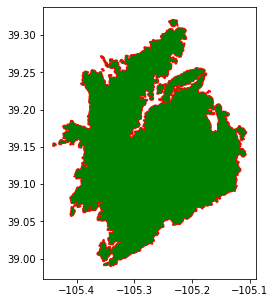

In [20]:
# Import geojson as GeoDataFrame
rcew_boundary = gpd.read_file(path.join(data_path, 'Hay_sch_polys.geojson')) 

# Plot GedDataFrame to check the data
rcew_boundary.plot(figsize=(10, 5), edgecolor='red',facecolor = "green")

# GEDI metadata

In order to effectively use GEDI data, it's important to know the file structure and how the data is organized within the .h5 files. There are a few ways to do this. 

One way would be to find the metadata, either from the downloaded data or online. GEDI L4A data has [documentation online](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density_V2.html) explaining all the variables stored within the files and what they represent. 

Even with this information, it can still be helpful to open your file in python and check the key names stored within the files. To do this, we can open up just one of the files we'll be using and look at the keys with `.keys()`.

In [21]:
# Creating a list of all GEDI files we're going to open
indir = path.join(data_path, 'GEDI_4A')
gedi_files_list = glob(path.join(indir, 'GEDI04_A*.h5'))
gedi_files_list


['input\\GEDI_4A\\GEDI04_A_2019113131121_O02045_02_T01195_02_002_02_V002.h5',
 'input\\GEDI_4A\\GEDI04_A_2019120163934_O02156_03_T05162_02_002_02_V002.h5',
 'input\\GEDI_4A\\GEDI04_A_2019127135651_O02263_03_T02163_02_002_02_V002.h5']

In [22]:
# Opening up the first GEDI file to check the metadata
hf = h5py.File(gedi_files_list[0], 'r')
# Getting a list of the BEAM names as well as other data in the file
hf.keys()

<KeysViewHDF5 ['ANCILLARY', 'BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']>

You'll notice that these are the name of each of the 8 beams that GEDI uses to collect data, in addition to ancillary data and metadata. As this data is hierarchical, each of these beams also has keys for the data stored in it. We can repeat the same process of grabbing one of the beams and checking it's keys to see a list of the data available to us. In the output below you should see a key called `agbd`, which stands for aboveground biomass density. It's measured in megagrams per hectare(Mg/ha). It's not a direct measurement but the predicted amount of AGBD based on the GEDI realtive height metrics (RH) estimated at GEDI 2A readings. We will want this data from the GEDI beam, alongside the `lat_lowestmode` and `lon_lowestmode` in order to get the spatial coordinates of the readings. 

In [23]:
# Checking all of the variables that are stored within each BEAM 
beam0110 = hf.get('BEAM0110')
beam0110.keys()

<KeysViewHDF5 ['agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_prediction', 'agbd_se', 'agbd_t', 'agbd_t_se', 'algorithm_run_flag', 'beam', 'channel', 'degrade_flag', 'delta_time', 'elev_lowestmode', 'geolocation', 'l2_quality_flag', 'l4_quality_flag', 'land_cover_data', 'lat_lowestmode', 'lon_lowestmode', 'master_frac', 'master_int', 'predict_stratum', 'predictor_limit_flag', 'response_limit_flag', 'selected_algorithm', 'selected_mode', 'selected_mode_flag', 'sensitivity', 'shot_number', 'solar_elevation', 'surface_flag', 'xvar']>

In [24]:
# Closing the file connection
hf.close()

# Clipping the GEDI beams

To clip the GEDI beams, what we're actually doing is getting the indices of the readings in the dataset that are within our study area, and then subsetting the dataset to only include those readings. We then create a new `.h5` file, copy all the metadata and ancillary data from the original data we're clipping from, then write out the subsetted dataset to our new output file.  

In [39]:
# Creating a directory to write our modified data to
outdir = path.join(data_path, 'output_dir')

if not path.isdir(outdir):
  os.mkdir(outdir)

In [26]:
# Loop through all GEDI files and clip to study area
for infile in gedi_files_list:
    # Getting name of the original file and using it to create the output file name
    name, ext = path.splitext(path.basename(infile))
    subfilename = "{name}_sub{ext}".format(name=name, ext=ext)
    outfile = path.join(outdir, path.basename(subfilename))
    hf_in = h5py.File(infile, 'r')
    hf_out = h5py.File(outfile, 'w')
    print(infile)
        
    # Copy ANCILLARY and METADATA groups to output file
    var1 = ["/ANCILLARY", "/METADATA"]
    for v in var1:
        hf_in.copy(hf_in[v],hf_out)
    
    # Loop through BEAMXXXX groups
    for hf_key in list(hf_in.keys()):
        if hf_key.startswith('BEAM'):
            beam = hf_in[hf_key]
            # Find the shots that overlays the area of interest (RCEW)
            indices = clip_gedi_beam(beam=beam, gdf=rcew_boundary)
            # Copy BEAMS to the output file
            for key, value in beam.items():
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        copy_beam_to_outfile(key=key2, value=value2, out_file=hf_out, indices=indices)
                else:
                    copy_beam_to_outfile(key=key, value=value, out_file=hf_out, indices=indices)
    # Close both files 
    hf_in.close()
    hf_out.close()

input\GEDI_4A\GEDI04_A_2019113131121_O02045_02_T01195_02_002_02_V002.h5
input\GEDI_4A\GEDI04_A_2019120163934_O02156_03_T05162_02_002_02_V002.h5
input\GEDI_4A\GEDI04_A_2019127135651_O02263_03_T02163_02_002_02_V002.h5


# Opening clipped data

Now that we have clipped our data, we can open the output files we've created and only read in the variables we need for our analysis, those being `lat_lowestmode`, `lon_lowestmode`, and `agbd`. We can read the data from those variable into lists and load those lists into a `GeoDataFrame`. This is what we can then use to analyze and plot our data.  

In [34]:
# Creating lists to read the desired variables into
lat_lowestmode,lon_lowestmode, agbd = ([] for i in range(3))

# Looping through all files created in the cell above
for subfile in glob(path.join(outdir, 'GEDI04_A*.h5')):
    hf_in = h5py.File(subfile, 'r')
    for hf_key in list(hf_in.keys()):
        # Reading all beams that are in our files
        if hf_key.startswith('BEAM'):
            # Adding the latitude, longitude, and AGBD measurements to the lists we created
            beam = hf_in[hf_key]
            lat_lowestmode.extend(beam['lat_lowestmode'][:].tolist()) 
            lon_lowestmode.extend(beam['lon_lowestmode'][:].tolist()) 
            agbd.extend(beam['agbd'][:].tolist())
    hf_in.close()

# Zipping the lists together to associate the correct data with the correct latitude/longitude
geo_arr = list(zip(lat_lowestmode,lon_lowestmode, agbd))
# Reading the data into a pandas DataFrame
df = pd.DataFrame(geo_arr, columns=["lat_lowestmode","lon_lowestmode","agbd"])
# Turning the pandas DataFrame into a GeoDataFrame by extracting the geometry information from the latitude and longitude columns 
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode), crs = "EPSG:4326")
# Removing agbd measurements that have a no data value
gdf = gdf[gdf.agbd != -9999]
gdf

,lat_lowestmode,lon_lowestmode,agbd,geometry
164,39.183799,-105.249182,0.410315,POINT (-105.24918 39.18380)
166,39.183156,-105.248157,0.624369,POINT (-105.24816 39.18316)
682,39.156759,-105.217061,1.391625,POINT (-105.21706 39.15676)
683,39.156436,-105.216546,1.061925,POINT (-105.21655 39.15644)
684,39.156113,-105.216035,2.221455,POINT (-105.21603 39.15611)
...,...,...,...,...
6701,39.058506,-105.202866,14.237240,POINT (-105.20287 39.05851)
6702,39.058180,-105.202348,90.753761,POINT (-105.20235 39.05818)
6703,39.057856,-105.201831,182.482117,POINT (-105.20183 39.05786)
6704,39.057531,-105.201314,213.048965,POINT (-105.20131 39.05753)


# Plot the data!

We've now completed all the steps we need to plot GEDI 4A data! Here we'll plot it with the boundary to show how it was clipped. 

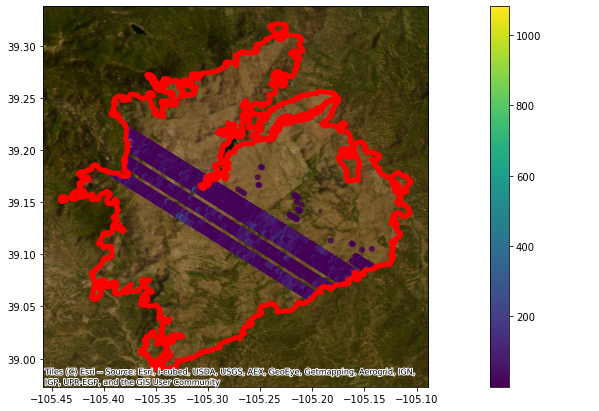

In [45]:
fig, ax = plt.subplots(figsize=(22, 7))
rcew_boundary.geometry.boundary.plot(ax=ax, edgecolor='red', linewidth=5)
gdf.plot(ax=ax, column='agbd', linewidth=0, legend=True, alpha = 0.8)
ctx.add_basemap(ax, crs=rcew_boundary.crs.to_string(), source=ctx.providers.Esri.WorldImagery)

# Save Geodataframe as a GeoJSON file

Now in we are saving the geodataframe with all information extracted from GEDI04_A file into a GeoJSON file. Geojson file can be opended in most of the geospatial propriotory software as well. 

In [40]:
gdf.to_file(path.join(outdir,"GEDI_4A_Hayman.geojson"), driver = "GeoJSON" )